# How to run this notebook:

**Option 1: Run in jupyter notebook**

Assign 1 ENSEMBLE MEMBER (0-600), run

**Option 2: Run with papermill in terminal (parameterisation of ENSEMBLE MEMBER)**

```sh
conda activate baur-et-al-srm-commitment
cd notebooks  
./run_forcing_adj.sh 0 600
```

**What this notebook does**

1. For a given ensemble member, determine what forcing pathway is required to follow a 1.5C compliant trajectory. The choice of whether to start with SSP1-2.6 or SSP1-1.9 or SSP2-4.5 in this notebook is fairly unimportant, but SSP2-4.5 resembles WG3 NDC-aligned pathways closest so choose this.

**To be done in other notebooks**

2. Run WG3 scenarios until 2500
3. Calculate the difference between the forcing in the WG3 scenario and the forcing required to follow a 1.5C compliant trajectory, this difference is the extra SRM required to go from the scenario to a a 1.5C compliant trajectory

In [1]:
#  specify default values which may be overridden by values specified at execution time (papermill)
ENSEMBLE_MEMBER = 0

In [2]:
assert ENSEMBLE_MEMBER < 600

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import json
import os
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openscm_runner
import pymagicc.io
import scmdata
from numpy.polynomial import Polynomial

# from tqdm.autonotebook import tqdm

import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/openscm_runner/progress.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<IPython.core.display.Javascript object>

In [5]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [6]:
openscm_runner.adapters.MAGICC7.get_version()

'v7.5.3'

<IPython.core.display.Javascript object>

## Load probabilistic distribution

Here we just extract one ensemble member, the process will need to be repeated over all ensemble members.

In [7]:
plots_folder = Path(utils.PLOTS_DIR / "ensemble_15_trajectories/")

<IPython.core.display.Javascript object>

In [8]:
with open(os.environ["MAGICC_AR6_PROBABILISTIC_DISTRIBUTION"]) as f:
    prob_dist = json.load(f)

display(prob_dist["description"])
cfg_to_run = [
    d for d in prob_dist["configurations"] if d["paraset_id"] == ENSEMBLE_MEMBER
]
assert len(cfg_to_run) == 1
cfg_to_run = {k.lower(): v for k, v in cfg_to_run[0]["nml_allcfgs"].items()}

'IPCC AR6 config drawn on 9th Feb 2021. Sub-sample set 0fd0f62 from derived metrics set f023edb. Drawn in 532_plot_and_save_subsampled_distribution.ipynb.'

<IPython.core.display.Javascript object>

In [9]:
# # this can help see where the config lies in the overall distribution
# import pandas as pd

# all_cfgs_df = pd.DataFrame(
#     [{**c["nml_allcfgs"], "id": c["paraset_id"]} for c in prob_dist["configurations"]]
# )
# all_cfgs_df["member of interest"] = all_cfgs_df["id"] == ENSEMBLE_MEMBER
# all_cfgs_df = all_cfgs_df.set_index("id")
# # print(all_cfgs_df["CORE_CLIMATESENSITIVITY"].idxmin())

# import seaborn as sns

# for c in all_cfgs_df:
#     em_val = all_cfgs_df[c].loc[ENSEMBLE_MEMBER]
#     if isinstance(em_val, (str, list, bool, np.bool_)):
#         continue

#     perc_99 = all_cfgs_df[c].quantile(0.99)
#     perc_1 = all_cfgs_df[c].quantile(0.01)

#     if (em_val < perc_1) or (em_val > perc_99):
#         print(c)
#         sns.displot(data=all_cfgs_df, x=c, hue="member of interest", multiple="dodge")
#         plt.show()

<IPython.core.display.Javascript object>

## Common configs

Configuration to apply to all runs

In [10]:
common_cfgs = {
    "startyear": 1750,
    "endyear": 2500,
    "out_dynamic_vars": [  ### determines which variables are outputted (could also set in MAGCFG_DEFAUKTAKK.CFG OUT-TEMPERATURE=1 instead)
        "DAT_SURFACE_TEMP",
        "DAT_TOTAL_INCLVOLCANIC_RF",
    ],
    "out_ascii_binary": "BINARY",
    "out_binary_format": 2,
}
common_cfgs

{'startyear': 1750,
 'endyear': 2500,
 'out_dynamic_vars': ['DAT_SURFACE_TEMP', 'DAT_TOTAL_INCLVOLCANIC_RF'],
 'out_ascii_binary': 'BINARY',
 'out_binary_format': 2}

<IPython.core.display.Javascript object>

In [11]:
# sets scaling of solar effective radiative forcing
# Zeb: This was a hack to see if it made our lives easier by getting rid of the oscillations.
overrides = {
    "RF_SOLAR_SCALE".lower(): 0,
}

<IPython.core.display.Javascript object>

In [12]:
openscm_runner_output_names = [
    "Surface Temperature",
    "Effective Radiative Forcing",
]
openscm_runner_output_names

['Surface Temperature', 'Effective Radiative Forcing']

<IPython.core.display.Javascript object>

## First run config

Configs for our first run. We just use a common scenario to get ourselves in the right ballpark.

In [13]:
# cfg_to_run are the ensemble specific parameters
first_run_config = {**common_cfgs, **cfg_to_run}
# first_run_config

<IPython.core.display.Javascript object>

Scenario config too (use SSP245 to determine the 1.5°C-trajectory because it's closest to the WG3 NDC-like pathways)

In [14]:
scenario = "ssp245"

scenario_emissions = pymagicc.io.MAGICCData(
    os.path.join(
        openscm_runner.adapters.MAGICC7._run_dir(),
        "rcmip",
        f"{scenario.upper()}_EMMS.SCEN7",
    )
)
scenario_emissions["variable"] = scenario_emissions["variable"].apply(
    lambda x: x.replace("NMVOC", "VOC")
)
scenario_emissions["unit"] = scenario_emissions["unit"].apply(
    lambda x: x.replace("NMVOC", "VOC")
)

<IPython.core.display.Javascript object>

In [15]:
## concat all configs together
first_run_config = {
    **first_run_config,
    **overrides,
    "RUNNAME": scenario,
}
run_config = [first_run_config]
out_config = {"MAGICC7": ("RUNNAME",)}

res_raw_first_run = openscm_runner.run(  # writes SCEN7-file to /run-directory
    {"MAGICC7": run_config},
    scenario_emissions,
    output_variables=openscm_runner_output_names,
    out_config=out_config,
)
res_raw_first_run["iteration"] = 0

Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

<IPython.core.display.Javascript object>

In [16]:
res_raw_first_run.filter(region="World").timeseries(time_axis="year")

time                                                                                                        1750  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                               
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change   0.0   
                                                                      W/m^2 Effective Radiative Forcing      0.0   

time                                                                                                            1751  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.021043   
                                                                      W/m^2 Effective Radiative Forcing     0.100231   

time                                                                                                            1752  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.030870   
                                                                      W/m^2 Effective Radiative Forcing     0.108626   

time                                                                                                            1753  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.036407   
                                                                      W/m^2 Effective Radiative Forcing     0.105016   

time                                                                                                            1754  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.038264   
                                                                      W/m^2 Effective Radiative Forcing     0.089092   

time                                                                                                            1755  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.039579   
                                                                      W/m^2 Effective Radiative Forcing     0.034038   

time                                                                                                            1756  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.035514   
                                                                      W/m^2 Effective Radiative Forcing     0.013630   

time                                                                                                            1757  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                   
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change  0.021288   
                                                                      W/m^2 Effective Radiative Forcing     0.057298   

time                                                                                                            1758  \
RUNNAME climate_model iteration model       regi

<IPython.core.display.Javascript object>

In [17]:
def plot_res(
    srun,  # T and RF output
    axes_vars,  # subplots
    palette=None,
    background_lines="tab:grey",
    target_temperature=None,
    target_colour="tab:green",
):
    if palette is None:
        palette = {
            "Surface Air Temperature Change": "tab:red",
            "Effective Radiative Forcing": "tab:blue",
        }

    time_axis = srun.timeseries(
        time_axis="year"
    ).columns.tolist()  # simple list with years 1700, 1701...2500
    max_iteration = max(srun.get_unique_meta("iteration"))

    for ax, vfilter in axes_vars:
        ax.clear()
        vdf = srun.filter(
            variable=vfilter
        )  # filter for the single variables (T and RF)
        for vvdf in vdf.groupby("variable"):
            variable = vvdf.get_unique_meta("variable", True)
            for subset, colour, zorder, linewidth in [
                (
                    vvdf.filter(
                        iteration=max_iteration
                    ),  #### =subset - WHAT DOES THIS FILTER?
                    palette[variable],  ### colour
                    4,
                    3,
                ),
                (
                    vvdf.filter(
                        iteration=max_iteration, keep=False, log_if_empty=False
                    ),
                    background_lines,
                    2,
                    1,
                ),
            ]:
                if subset.empty:  ## checks if subset is empty? But subset is not empty
                    # subset can be empty if we are plotting the first run and there are
                    # no 'background' lines to plot
                    print(
                        f"subset for variable {variable} to be plotted with colour {colour} is empty"
                    )
                    continue

                ax.plot(
                    time_axis,  # simple list with years 1700, 1701...2500
                    subset.values.T.squeeze(),  # only get the data values
                    color=colour,
                    zorder=zorder,
                    linewidth=linewidth,
                    alpha=0.7,
                )

        if target_temperature is not None:
            ttfilt = target_temperature.filter(variable=vfilter, log_if_empty=False)
            if not ttfilt.empty:
                ax.plot(
                    time_axis,
                    ttfilt.values.squeeze(),
                    color=target_colour,
                )

    return [a for a in axes_vars]

<IPython.core.display.Javascript object>

subset for variable Effective Radiative Forcing to be plotted with colour tab:grey is empty
subset for variable Surface Air Temperature Change to be plotted with colour tab:grey is empty


[(<AxesSubplot: >, ['*Forcing*']), (<AxesSubplot: >, ['*Temperature*'])]

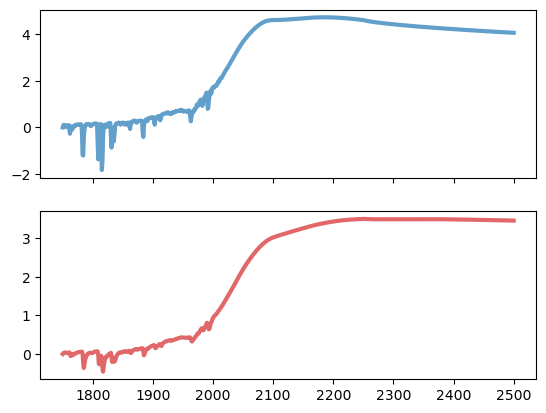

<IPython.core.display.Javascript object>

In [18]:
# papermill_description=scenarioprint

fig, axes = plt.subplots(nrows=2, sharex=True)

srun = res_raw_first_run.filter(region="World")


axes_vars = (
    (axes[0], ["*Forcing*"]),
    (axes[1], ["*Temperature*"]),
)

plot_res(srun, axes_vars)

In [19]:
srun.timeseries()

time                                                                                                        1750-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change                  0.0   
                                                                      W/m^2 Effective Radiative Forcing                     0.0   

time                                                                                                        1751-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.021043   
                                                                      W/m^2 Effective Radiative Forcing                0.100231   

time                                                                                                        1752-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.030870   
                                                                      W/m^2 Effective Radiative Forcing                0.108626   

time                                                                                                        1753-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.036407   
                                                                      W/m^2 Effective Radiative Forcing                0.105016   

time                                                                                                        1754-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.038264   
                                                                      W/m^2 Effective Radiative Forcing                0.089092   

time                                                                                                        1755-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.039579   
                                                                      W/m^2 Effective Radiative Forcing                0.034038   

time                                                                                                        1756-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspecified K     Surface Air Temperature Change             0.035514   
                                                                      W/m^2 Effective Radiative Forcing                0.013630   

time                                                                                                        1757-01-01 00:00:00  \
RUNNAME climate_model iteration model       region run_id scenario    unit  variable                                              
ssp245  MAGICCv7.5.3  0         unspecified World  0      unspe

<IPython.core.display.Javascript object>

## Derive goal-temperature trajectory

We want to make a smooth temperature trajectory towards 1.5C.

In [20]:
# First year in which we can change the ERF
START_SRM_YEAR = 2030  # 2020

# Max temperature we want to target
TARGET_MAX_TEMP = 1.5
# TARGET_MAX_TEMP = 2.0

<IPython.core.display.Javascript object>

In [21]:
def get_quadratic_fit(
    year_zero,  # year_zero = 2020
    year_zero_warming,  # T in 2020
    year_zero_gradient,  # 10 year gradient
    zero_gradient_temp,  # first segment max
):
    c = year_zero_warming  # T in 2020
    b = year_zero_gradient  # 10 year gradient
    a = -(b**2) / (4 * (zero_gradient_temp - c))  # vertex of quadratic function
    #  first_segment_end_year = -b / (2 * a) + year_zero
    first_segment_end_year = year_zero - b / (2 * a)
    print(first_segment_end_year)

    quadratic = Polynomial([c, b, a])

    return quadratic, np.ceil(
        first_segment_end_year
    )  # np.ceil returns the ceiling of the input, element wise (Betrag; immer hochgerundet)
    # np.ceil gives quadratic end year


def get_sigmoid(
    sigmoid_size,  # size of the overshoot
    sigmoid_ndrop_years,  # x-offset (width of sigmoid function)
    zero_year,  # second segment start year
    zero_year_warming,  # second segment start year warming
):
    # vary sigmid width depending on size of overshoot
    #  sigmoid_ndrop_years = sigmoid_ndrop_years + (sigmoid_size * sigmoid_ndrop_years * 2)
    #   sigmoid_ndrop_years_ = sigmoid_ndrop_years + (sigmoid_size * 10)

    def sigmoid(inp):
        sigmoid_slope = 0.8
        # sigmoid_slope = 1 - sigmoid_size

        return zero_year_warming - sigmoid_size / (
            1 + np.exp(-(inp - zero_year - sigmoid_ndrop_years / 2)) ** sigmoid_slope
        )

    return sigmoid, second_segment_start_year + sigmoid_ndrop_years

<IPython.core.display.Javascript object>

In [22]:
gsat = res_raw_first_run.filter(region="World", variable="*Temp*")
target = gsat.timeseries(time_axis="year").copy()
years = target.columns.values.squeeze()  # list of years

srm_year_warming = gsat.filter(
    year=START_SRM_YEAR
).values.squeeze()  # T in the year of SRM start (2020)
recent_warming_gradient = (  # warming gradient of "original" pathway in the first 10 years after SRM start (2020 - 2030)
    gsat.filter(year=range(START_SRM_YEAR, START_SRM_YEAR + 10))
    .linear_regression_gradient("K / yr")["gradient"]
    .values.squeeze()
)
five_years_more_warming = (
    recent_warming_gradient * 5
)  # warming after 5 years of following this gradient
five_years_more_warming_total = (
    srm_year_warming + five_years_more_warming
)  # total warming 5 years after SRM start with gradient


### 2 categories of pathways
# 1. Impossible to avoid overshoot, smooth out ---> sigmoidal function
if five_years_more_warming_total > TARGET_MAX_TEMP:
    first_segment_max = five_years_more_warming_total
    second_segment_min = TARGET_MAX_TEMP
    print(first_segment_max)
    # should be between 1.5 and the temperature in SRM_START_YEAR+5
    print('overshoot')
# 2. smooth approach to 1.5 ---> quadratic function
else:
    first_segment_max = TARGET_MAX_TEMP
    second_segment_min = None
    print('smooth approach to target')
    # should be anywhere below 1.5

### First segment after 2020
quadratic, first_segment_end_year = get_quadratic_fit(
    START_SRM_YEAR, srm_year_warming, recent_warming_gradient, first_segment_max
)
# first segment end year = peak of the quadratic function
first_segment_years = np.arange(
    START_SRM_YEAR, (first_segment_end_year)
)  # list years from start to end
# replace the years of the first segment with the target temperatures during first segment
target[first_segment_years] = quadratic(first_segment_years - START_SRM_YEAR)


1.7847098644332315
overshoot
2040.0


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'first segment modified')

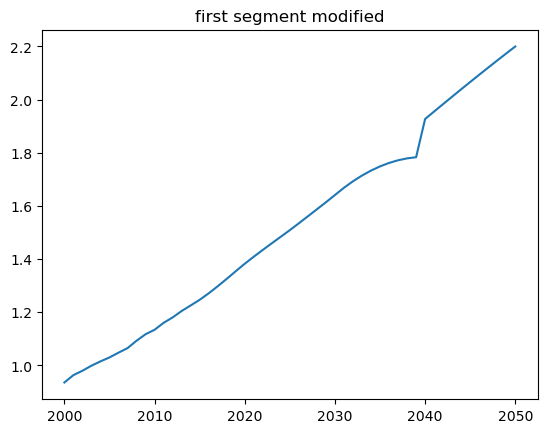

<IPython.core.display.Javascript object>

In [23]:
target_run = scmdata.ScmRun(target)
plt.plot(
    target_run.filter(year=range(2000, 2051))
    .timeseries(time_axis="year")
    .columns.tolist(),  # simple list with years 1700, 1701...2500
    target_run.filter(
        year=range(2000, 2051)
    ).values.T.squeeze(),  # only get the data values
)
plt.title("first segment modified")

In [24]:
### Second segment after 2020
if second_segment_min is None:
    print("smooth approach to target - no sigmoidal func")
    target.loc[
        :, int(first_segment_years[-1]) + 1 :
    ] = first_segment_max  # set all years after to 1.5

else:
    print("sigmoidal func")
    second_segment_start_year = first_segment_years[-1] + 1  # first year of segment 2
    second_segment_start_year_warming = target[
        first_segment_years[-1]
    ].values.squeeze()  # first T value of segment 2

    sigmoid, second_segment_end_year = get_sigmoid(
        sigmoid_size=first_segment_max - second_segment_min,
        sigmoid_ndrop_years=10,
        zero_year=second_segment_start_year,
        zero_year_warming=second_segment_start_year_warming,
    )

    second_segment_years = np.arange(second_segment_start_year, second_segment_end_year)

    target[second_segment_years] = sigmoid(second_segment_years)
    target.loc[:, int(second_segment_years[-1]) + 1 :] = second_segment_min


target = scmdata.ScmRun(target)

sigmoidal func


<IPython.core.display.Javascript object>

subset for variable Effective Radiative Forcing to be plotted with colour tab:grey is empty
subset for variable Surface Air Temperature Change to be plotted with colour tab:grey is empty


[(<AxesSubplot: >, ['*Forcing*']), (<AxesSubplot: >, ['*Temperature*'])]

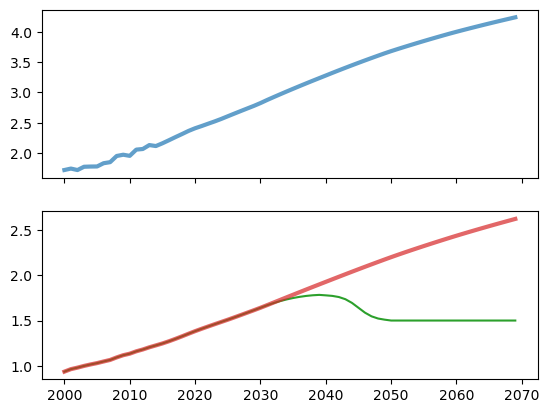

<IPython.core.display.Javascript object>

In [25]:
# papermill_description=scenario_build

fig, axes = plt.subplots(nrows=2, sharex=True)

srun = res_raw_first_run.filter(region="World")


axes_vars = (
    (axes[0], ["*Forcing*"]),
    (axes[1], ["*Temperature*"]),
)

plot_res(
    srun.filter(year=range(2000, 2070)),
    axes_vars,
    target_temperature=target.filter(year=range(2000, 2070)),  # green
)

## Iterate to find new forcing

In [26]:
def get_new_srm(
    current_srm, res_gsat, target, forcing_temp_scaling=2, forcing_lag_years=3
):
    current_srm_ts = current_srm.timeseries(time_axis="year")
    years = current_srm_ts.columns.values.squeeze()
    # get temperature difference of iteration before
    temp_difference = res_gsat.subtract(
        target, op_cols={"scenario": "res - target", "iteration": -1}
    ).values.squeeze()
    # the smaller the temperature difference the smaller the adjustment in that iteration
    forcing_adjustments = -temp_difference / forcing_temp_scaling
    # force the adjustments to zero if the temperature difference is below a certain threshold removes the oscillations
    close_years = np.abs(temp_difference) < 0.02
    if close_years.all():
        return "converged"

    forcing_adjustments[np.where(close_years)] = 0
    ## adjusts to change forcing `forcing_lag_years` years before the actual temperature difference
    forcing_adjustments = np.concatenate(
        [forcing_adjustments[forcing_lag_years:], np.zeros(forcing_lag_years)]
    )
    # set all forcing changes before START_SRM_YEAR to 0
    forcing_adjustments[: START_SRM_YEAR - common_cfgs["startyear"]] = 0

    new_forcing = current_srm_ts + forcing_adjustments

    return new_forcing

<IPython.core.display.Javascript object>

In [27]:
def write_qextra_file(forcing, out_file):
    ## overwrite the last 5 years to remove the oscillations
    for y in list(range(2496, 2500 + 1)):
        forcing[y] = forcing[2495]

    forcing = pymagicc.io.MAGICCData(forcing)
    forcing["todo"] = "SET"
    forcing.metadata["header"] = "Prescribed forcing file"
    forcing["ensemble_member"] = ENSEMBLE_MEMBER

    forcing.write(out_file, magicc_version=7)

<IPython.core.display.Javascript object>

In [28]:
# res_raw = output of original scenario
res = res_raw_first_run.copy()

<IPython.core.display.Javascript object>

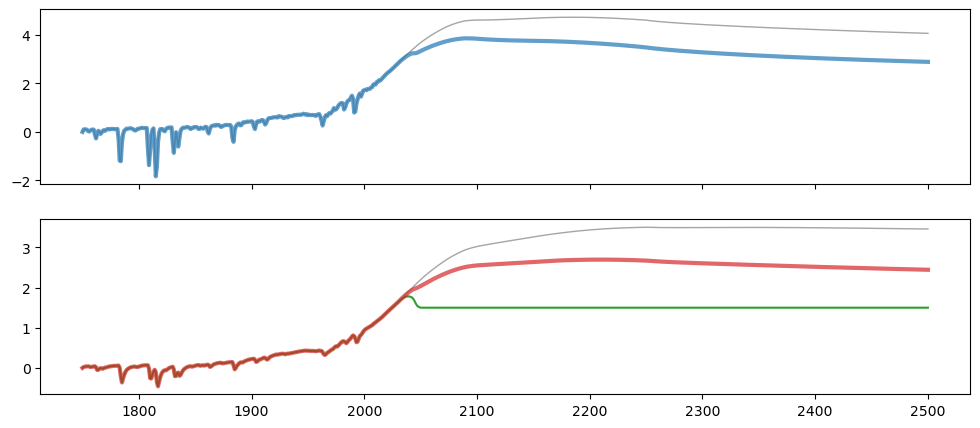

Iteration: 0


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

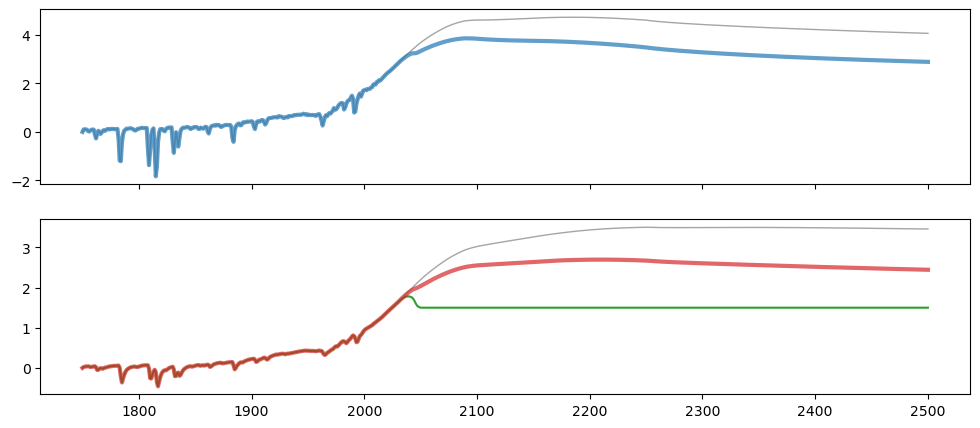

<IPython.core.display.Javascript object>

In [29]:
# papermill_description=iteration

N_STEPS = 15

fig, axes = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
holder = display(fig, display_id=True)

axes_vars = (
    (axes[0], ["*Forcing*"]),
    (axes[1], ["*Temperature*"]),
)

pyears = range(1750, 2500 + 1)

current_srm = scmdata.ScmRun(
    res_raw_first_run.filter(variable="*Forcing*", region="World").timeseries() * 0
)
current_srm["variable"] = "Radiative Forcing|Extra"

all_srms = current_srm.copy()


extra_rf_file = os.path.join(
    os.path.dirname(os.environ["MAGICC_EXECUTABLE_7"]),
    "..",
    "run",
    "15_SRM-ERF_trajectories",
    str(ENSEMBLE_MEMBER) + "_" + str(START_SRM_YEAR) + "_EXTRA_RF.IN",
)

for i in range(N_STEPS):
    print(f"Iteration: {i}")
    last_iteration = max(
        res.get_unique_meta("iteration")
    )  # always get last iteration to continue building on

    # get new forcing
    current_srm = get_new_srm(
        all_srms.filter(iteration=last_iteration),
        res.filter(variable="*Temp*", region="World", iteration=last_iteration),
        target,
        forcing_temp_scaling=2,
        forcing_lag_years=1,
    )
    if isinstance(current_srm, str) and current_srm == "converged":
        print("Converged, exiting now")
        break

    write_qextra_file(current_srm, extra_rf_file)

    run_cfg = [
        {
            **first_run_config,
            "RUNNAME": scenario,
            **overrides,
            "RF_EXTRA_READ".lower(): 1,
            "FILE_EXTRA_RF": extra_rf_file,
        }
    ]
    out_config = {"MAGICC7": ("RUNNAME",)}

    res_raw = openscm_runner.run(
        {"MAGICC7": run_cfg},
        # emissions ignored because of config but have to put
        # something in for OpenSCM-Runner
        scenario_emissions,
        output_variables=openscm_runner_output_names,
        out_config=out_config,
    )
    res_raw["iteration"] = last_iteration + 1
    current_srm["iteration"] = last_iteration + 1

    # append each iteration to res
    res = scmdata.run_append([res, res_raw])
    all_srms = scmdata.run_append([all_srms, scmdata.ScmRun(current_srm)])

    plot_res(
        res.filter(region="World").filter(year=pyears),
        axes_vars,
        target_temperature=target.filter(year=pyears),
    )

    holder.update(fig)

# save_path = Path(plots_folder / f"{str(ENSEMBLE_MEMBER)}_{str(START_SRM_YEAR)}.png")
# plt.savefig(save_path)

In [30]:
res.filter(iteration=15, region="World").tail()

Filtered ScmRun is empty!
Stack (most recent call last):
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
    self.io_loop.start()
  File "/data/ubuntu-znicholls/miniconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site

,,,,,,,,time,1750-01-01 00:00:00,1751-01-01 00:00:00,1752-01-01 00:00:00,1753-01-01 00:00:00,1754-01-01 00:00:00,1755-01-01 00:00:00,1756-01-01 00:00:00,1757-01-01 00:00:00,1758-01-01 00:00:00,1759-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
RUNNAME,climate_model,iteration,model,region,run_id,scenario,unit,variable,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

In [33]:
# save final ERF output of 1.5-trajectory
last_iteration = max(res.get_unique_meta("iteration"))


def save_csv_output(var, var_abbr, var_long):
    global_last_iteration = res.filter(
        iteration=last_iteration, region="World", variable=var
    )
    global_last_iteration["ensemble_member"] = ENSEMBLE_MEMBER

    global_last_iteration.to_csv(
        os.path.join(
            utils.DATA_DIR,
            f"15_{var_abbr}_trajectories",
            f"{str(ENSEMBLE_MEMBER)}_{str(START_SRM_YEAR)}_{var_long}.csv",
        )
    )


save_csv_output("Effective Radiative Forcing", "ERF", "EXTRA_RF")
save_csv_output("Surface Air Temperature Change", "T", "SURFACE_TEMP")

<IPython.core.display.Javascript object>

In [ ]:
# all_srms.lineplot(hue="iteration")

In [ ]:
# fig, axes = plt.subplots(nrows=2, sharex=True)

# axes_vars = (
#    (axes[0], ["*Forcing*"]),
#    (axes[1], ["*Temperature*"]),
# )

# pyears = range(2020, 2500 + 1)
# plot_res(
#    res.filter(region="World").filter(year=pyears),
#    axes_vars,
#    target_temperature=target.filter(year=pyears),
# )